In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

import tensorflow as tf
from PIL import Image
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2 as cv

import random
from sklearn.metrics import classification_report, confusion_matrix
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, BatchNormalization,Input,concatenate, AveragePooling2D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os


2025-02-07 14:22:12.494161: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-07 14:22:12.717498: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-07 14:22:12.891518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738920133.046615   36078 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738920133.095041   36078 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 14:22:13.489185: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# create dictionary of relationship between label and sign
categories = {0:"A", 1: "C", 2:"3", 3:"G", 4: "I", 5: "K", 6: "N",7: "O", 8: "R", 9: "S", 10: "W"}

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from skimage.io import imread

# Define the dataset path
data_path = "Signs"

# Check if dataset exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset folder '{data_path}' not found!")

# Initialize lists
file_list = []
image_list = []
label_list = []

# Get category folders (A, B, C, etc.)
categories = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

for category in categories:
    category_path = os.path.join(data_path, category)
    print(f"Checking category: {category}")

    # Get image files directly inside category folders
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"⚠️ Warning: No images found in {category_path}")

    for img_file in image_files:
        file_path = os.path.join(category_path, img_file)
        file_list.append(file_path)
        label_list.append(category)  # Assign folder name as label

        # Load and store image
        img = imread(file_path)
        image_list.append(np.array(img))

# Create a Pandas DataFrame
df = pd.DataFrame({'file': file_list, 'image': image_list, 'label': label_list})

# Print first 5 rows to verify data loading
if df.empty:
    print("❌ No images found! Check your dataset structure.")
else:
    print(df.head())

# Save DataFrame (Optional)
df.to_csv("signs_dataset.csv", index=False)


Checking category: s
Checking category: w
Checking category: k
Checking category: c
Checking category: g
Checking category: A
Checking category: o
Checking category: i
Checking category: r
Checking category: n
               file                                              image label
0   Signs/s/773.jpg  [[197, 199, 198, 196, 195, 196, 197, 196, 198,...     s
1   Signs/s/871.jpg  [[200, 200, 201, 201, 202, 203, 203, 202, 203,...     s
2   Signs/s/148.jpg  [[186, 187, 188, 186, 187, 188, 189, 189, 190,...     s
3  Signs/s/1012.jpg  [[191, 191, 192, 192, 192, 192, 192, 193, 192,...     s
4  Signs/s/2777.jpg  [[181, 180, 181, 182, 182, 182, 182, 181, 181,...     s


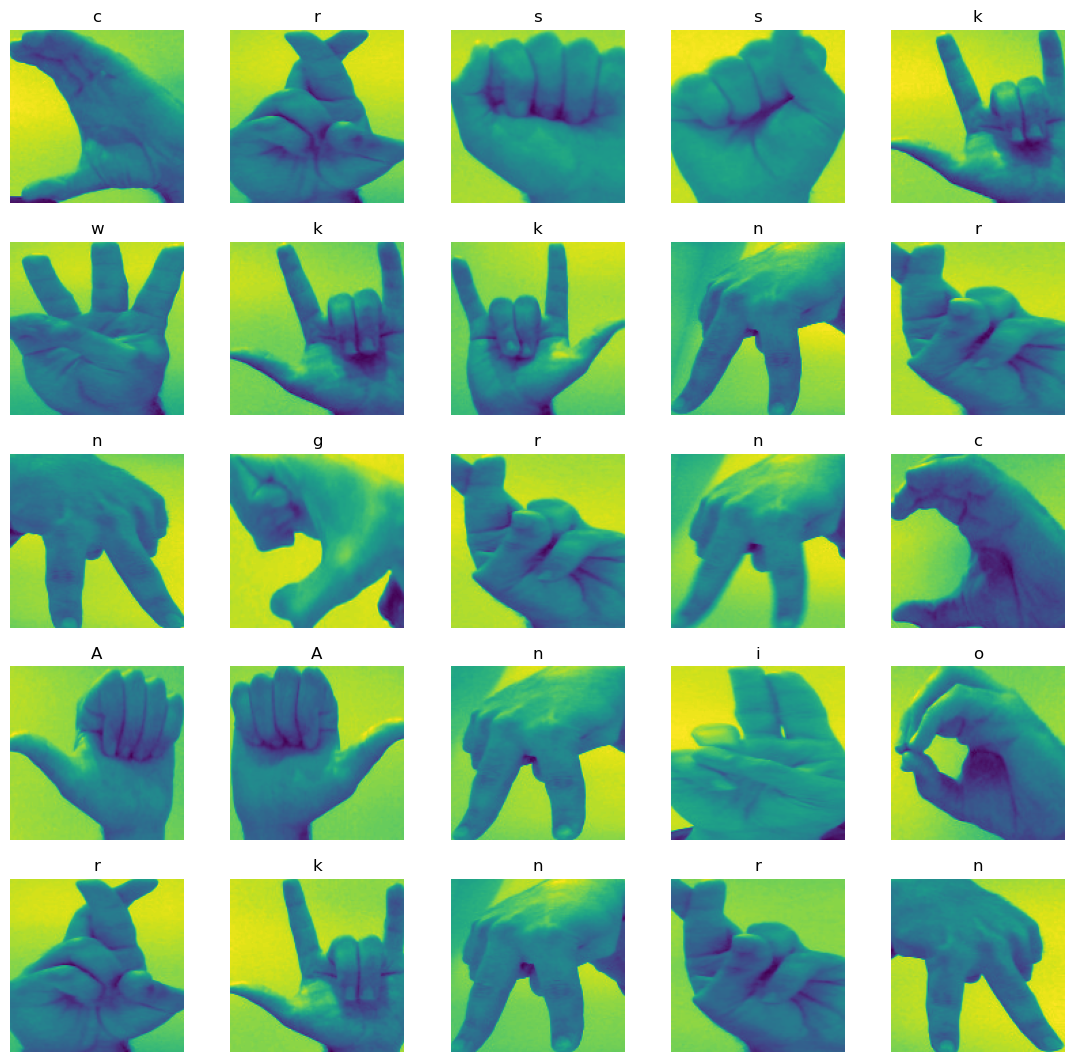

In [4]:
plt.figure(figsize=(11,11))

# Select 25 random images for visualization
for i in range(1, 26):
    plt.subplot(5, 5, i)
    plt.tight_layout()
    plt.axis('off')

    # Ensure random selection from the dataset
    rand_index = random.randint(0, len(file_list) - 1)
    rand_img = imread(file_list[rand_index])
    
    plt.imshow(rand_img)
    plt.title(label_list[rand_index])

plt.show()


/tmp/ipykernel_36078/1620340356.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(sign_freq, x='label', y='count', palette='icefire')


Text(0.5, 1.0, 'Count of Images by Sign')

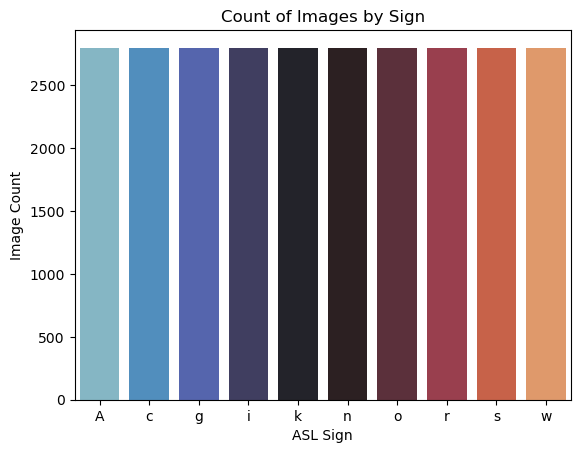

In [5]:
# visualize distribution of images by sign in dataset
sign_freq = df['label'].value_counts().reset_index().sort_values('label')
sns.barplot(sign_freq, x='label', y='count', palette='icefire')
plt.xlabel('ASL Sign')
plt.ylabel('Image Count')
plt.title('Count of Images by Sign')

In [6]:

# Split the dataset into training and testing sets (75% train, 25% test)
x_train, x_test0, y_train, y_test0 = train_test_split(df['file'], df['label'], test_size=0.25, random_state=42, stratify=df['label'])

# Further split the testing set into validation and testing sets (50% of the remaining 25%)
x_test, x_val, y_test, y_val = train_test_split(x_test0, y_test0, test_size=0.5, random_state=42, stratify=y_test0)

# Combine the file paths and labels into DataFrames for each set
train = pd.concat([x_train, y_train], axis=1).reset_index(drop=True)
test = pd.concat([x_test, y_test], axis=1).reset_index(drop=True)
val = pd.concat([x_val, y_val], axis=1).reset_index(drop=True)

print(train['label'].dtype)
print(test['label'].dtype)
print(val['label'].dtype)

object
object
object


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the image size and batch size
image_size = 128
batchsize = 32

datagen_train = ImageDataGenerator(
    rescale=1.0/255,                # Normalize the training images
    rotation_range=20,              # Random rotation from -20 to 20 degrees
    width_shift_range=0.1,          # Random width shift
    height_shift_range=0.1,         # Random height shift
    shear_range=0.2,                # Random shear
    #zoom_range=0.01,                 # Random zoom
    horizontal_flip=True,           # Random horizontal flip
    vertical_flip=True,             # Random vertical flip
    fill_mode='nearest',            # Fill mode for newly created pixels
)
# Initialize the ImageDataGenerator for test and validation data
datagen_test = ImageDataGenerator(rescale=1.0/255)

# Load training data
train_data = datagen_train.flow_from_dataframe(
    dataframe=train,
    x_col='file',
    y_col='label',
    target_size=(image_size, image_size),
    color_mode='grayscale',  # Set color mode to grayscale
    shuffle=True,
    batch_size=batchsize,
    class_mode='categorical'
)

# Load test data
test_data = datagen_test.flow_from_dataframe(
    dataframe=test,
    x_col='file',
    y_col='label',
    target_size=(image_size, image_size),
    color_mode='grayscale',  # Set color mode to grayscale
    shuffle=False,
    batch_size=batchsize,
    class_mode='categorical'
)

# Load validation data
val_data = datagen_test.flow_from_dataframe(
    dataframe=val,
    x_col='file',
    y_col='label',
    target_size=(image_size, image_size),
    color_mode='grayscale',  # Set color mode to grayscale
    shuffle=False,
    batch_size=batchsize,
    class_mode='categorical'
)

Found 21000 validated image filenames belonging to 10 classes.
Found 3500 validated image filenames belonging to 10 classes.
Found 3500 validated image filenames belonging to 10 classes.


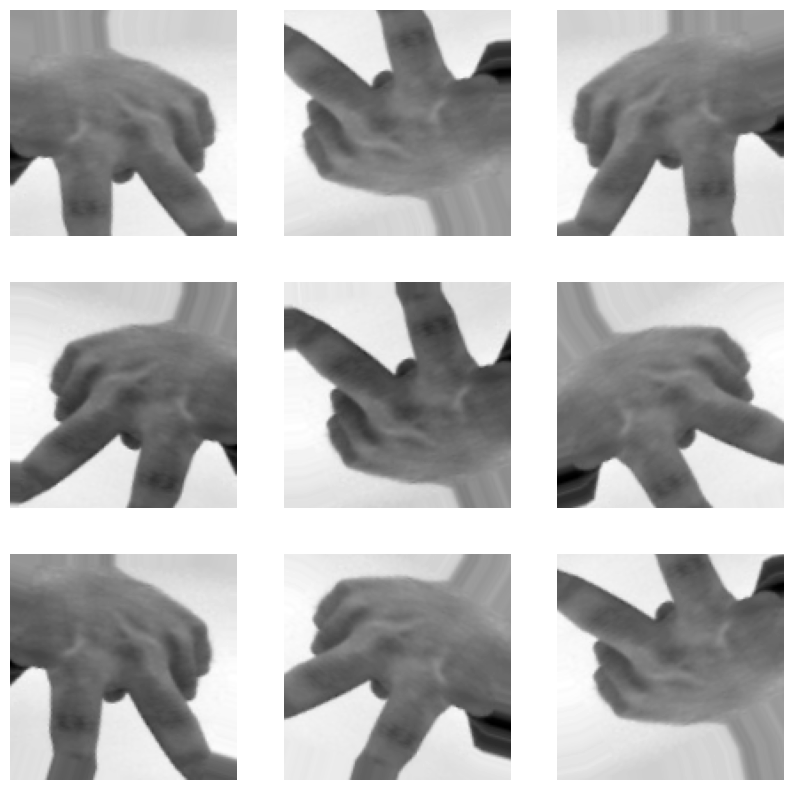

In [8]:

# Function to plot augmented images
def plot_augmented_images(datagen, sample_image, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        # Apply augmentation
        augmented_image = datagen.random_transform(sample_image)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image.squeeze(), cmap='gray')  # Assuming grayscale
        plt.axis("off")
    plt.show()

# Load a batch of images from the training dataset
for images, _ in train_data:
    # Take the first image from the batch
    sample_image = images[0]
    break

# Plot augmented images
plot_augmented_images(datagen_train, sample_image)

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras import regularizers
from keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam

# Initialize the model
model = Sequential()

# First convolutional layer with ReLU activation and L2 regularization
model.add(Conv2D(16, (3, 3), kernel_initializer=HeNormal(),
                 kernel_regularizer=regularizers.l2(0.02),  # L2 regularization
                 input_shape=(image_size, image_size, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.1))  # Dropout after activation

# Second convolutional layer with ReLU activation and L2 regularization
model.add(Conv2D(32, (3, 3), kernel_initializer=HeNormal(),
                 kernel_regularizer=regularizers.l2(0.02)))  # L2 regularization
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.1))  # Dropout after activation

# Third convolutional layer with ReLU activation and L2 regularization
model.add(Conv2D(64, (3, 3), kernel_initializer=HeNormal(),
                 kernel_regularizer=regularizers.l2(0.02)))  # L2 regularization
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.1))  # Dropout after activation

# Fourth convolutional layer with ReLU activation and L2 regularization
model.add(Conv2D(128, (3, 3), kernel_initializer=HeNormal(),
                 kernel_regularizer=regularizers.l2(0.02)))  # L2 regularization
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.2))  # Dropout after activation



# Flatten the output from the convolutional layers
model.add(Flatten())

# Fully connected layer with L2 regularization and dropout
model.add(Dense(256, activation='relu', kernel_initializer=HeNormal(),
                kernel_regularizer=regularizers.l2(0.02)))  # L2 regularization
model.add(Dropout(0.2))  # Dropout before output layer

# Output layer
model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()


/home/ali-raza-tareen/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-07 14:22:45.755400: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 126, 126, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,705,610 (6.51 MB)

 Trainable params: 1,705,610 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Initialize callbacks
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=10, restore_best_weights=True, verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)  # Monitor val_loss to reduce overfitting
checkpoint = ModelCheckpoint('my_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Compile the model with the Adam optimizer and a lower learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Set the number of epochs
epochs = 9  # Increased epochs for better training


In [11]:
# Train the model
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=[earlystop, reducelr, checkpoint]
)

Epoch 1/9


/home/ali-raza-tareen/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.1774 - loss: 8.5656
Epoch 1: val_loss improved from inf to 1.15012, saving model to my_model.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 276s 415ms/step - accuracy: 0.1776 - loss: 8.5598 - val_accuracy: 0.9611 - val_loss: 1.1501 - learning_rate: 0.0010
Epoch 2/9
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.7809 - loss: 1.3661
Epoch 2: val_loss improved from 1.15012 to 0.60704, saving model to my_model.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 271s 413ms/step - accuracy: 0.7810 - loss: 1.3658 - val_accuracy: 0.9814 - val_loss: 0.6070 - learning_rate: 0.0010
Epoch 3/9
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8829 - loss: 0.8581
Epoch 3: val_loss improved from 0.60704 to 0.51621, saving model to my_model.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 260s 395ms/step - accuracy: 0.8829 - loss: 0.8581 - val_accuracy: 0.9814 - val_loss: 0.5162 - learning_rate: 0.0010
Epoch 4/9
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.89

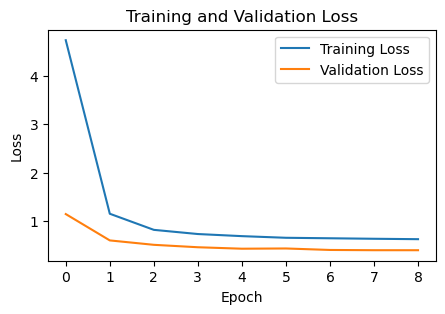

In [12]:

# Plotting the loss curve
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

In [13]:
# Predict on testing dataset and assess accuracy
probs = model.predict(test_data, verbose = 0)
y_pred = np.argmax(probs, axis = 1)
y_actual = test_data.labels

test_loss, test_accuracy = model.evaluate(test_data,verbose = 0)

print('Testing Accuracy:', test_accuracy)
print('Testing Loss:', test_loss, '\n')

correct = np.nonzero(y_pred==y_actual)[0]
incorrect = np.nonzero(y_pred!=y_actual)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0], '\n')

print(classification_report(y_pred, y_actual))

Testing Accuracy: 0.9940000176429749
Testing Loss: 0.39776918292045593 

Correct predicted classes: 3479
Incorrect predicted classes: 21 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       351
           1       0.99      1.00      1.00       348
           2       1.00      1.00      1.00       351
           3       1.00      0.97      0.98       361
           4       1.00      0.99      1.00       351
           5       0.99      1.00      0.99       345
           6       1.00      1.00      1.00       350
           7       0.96      1.00      0.98       338
           8       1.00      1.00      1.00       350
           9       1.00      0.99      0.99       355

    accuracy                           0.99      3500
   macro avg       0.99      0.99      0.99      3500
weighted avg       0.99      0.99      0.99      3500



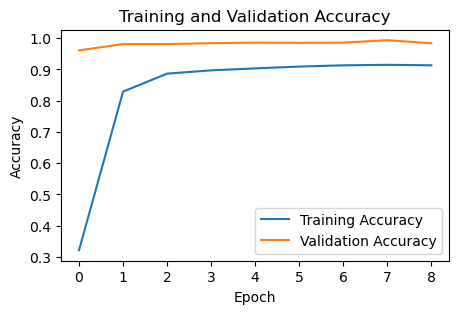

In [14]:
# Plotting the accuracy curve
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)
plt.show()


In [16]:
# Visualize confusion matrix of classifications
plt.figure(figsize = (15, 12))   
matrix = confusion_matrix(y_pred, y_actual)
matrixdf = pd.DataFrame(matrix, index=categories.values(), columns=categories.values())
sns.heatmap(matrixdf,annot=True,fmt='g')
plt.xlabel("Predicted Signs")
plt.ylabel("Actual Signs")
plt.title("Confusion Matrix")

AttributeError: 'list' object has no attribute 'values'

<Figure size 1500x1200 with 0 Axes>